### Lab 6: Regression


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from linear_regression import LinearRegression
import matplotlib.pyplot as plt

#### Loading Dataset 

In [16]:
def load_and_preprocess_housing():
    """Load and preprocess the Housing dataset with advanced preprocessing."""
    # Load data
    data = pd.read_csv('../data/Housing.csv')
    print(data.head())
    X = data.drop('medv', axis=1)
    y = data['medv']
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    
    # Apply power transform to handle skewed features
    power = PowerTransformer(method='yeo-johnson')
    X_transformed = power.fit_transform(X_imputed)
    
    # Apply PCA to reduce correlation and condition number
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_transformed)
    
    # Scale features to [-1, 1] range
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)
    
    # Scale target to [-1, 1] range
    y_scaled = 2 * (y - y.min()) / (y.max() - y.min()) - 1
    
    print(f"Reduced features from {X.shape[1]} to {X_pca.shape[1]}")
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")
    
    # Print condition number
    print(f"Condition number before PCA: {np.linalg.cond(X_transformed):.2e}")
    print(f"Condition number after PCA: {np.linalg.cond(X_scaled):.2e}")
    
    return X_scaled, y_scaled

In [17]:
# Load and preprocess data
print("Loading and preprocessing data...")
X, y = load_and_preprocess_housing()

Loading and preprocessing data...
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
Reduced features from 13 to 9
Explained variance ratio: 0.956
Condition number before PCA: 8.53e+00
Condition number after PCA: 1.00e+00


In [18]:
# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Add scaled bias term
bias_scale = 0.1
X_train = np.c_[np.ones(X_train.shape[0]) * bias_scale, X_train]
X_val = np.c_[np.ones(X_val.shape[0]) * bias_scale, X_val]
X_test = np.c_[np.ones(X_test.shape[0]) * bias_scale, X_test]

### Finding Optimal Tau

In [19]:
def find_optimal_regularization(X_train, y_train, X_val, y_val, regularization_range):
    """Find optimal regularization parameter with improved stability."""
    best_regularization = None
    best_error = float('inf')
    errors = []
    
    print("\nFinding optimal regularization parameter...")
    print(f"{'Regularization':>12s}\t{'Validation MSE':>12s}")
    print("-" * 40)
    
    # Add small constant to diagonal for numerical stability
    eps = 1e-8
    X_train_stable = X_train.copy()
    X_val_stable = X_val.copy()
    
    # Ensure matrices are well-conditioned
    if X_train.shape[0] > X_train.shape[1]:
        X_train_stable = X_train_stable + eps * np.eye(X_train.shape[0], X_train.shape[1])
        X_val_stable = X_val_stable + eps * np.eye(X_val.shape[0], X_val.shape[1])
    
    for regularization in regularization_range:
        try:
            model = LinearRegression(tau=regularization)
            model.fit(X_train_stable, y_train)
            y_pred = model.predict(X_val_stable)
            error = np.mean((y_val - y_pred) ** 2)
            
            if np.isfinite(error):
                errors.append(error)
                print(f"{regularization:12.6e}\t{error:12.6f}")
                
                if error < best_error:
                    best_error = error
                    best_regularization = regularization
            else:
                print(f"{regularization:12.6e}\tInvalid (non-finite error)")
                
        except Exception as e:
            print(f"{regularization:12.6e}\tFailed: {str(e)}")
    
    if best_regularization is None:
        raise ValueError("Could not find valid regularization parameter")
    
    return best_regularization, errors

In [20]:
# Try regularization with smaller range
regularization_range = np.logspace(-2, 2, 9)
best_regularization, validation_errors = find_optimal_regularization(
    X_train, y_train, X_val, y_val, regularization_range
)

print(f"\nBest regularization parameter: {best_regularization:.6e}")


Finding optimal regularization parameter...
Regularization	Validation MSE
----------------------------------------
1.000000e-02	    0.040167
3.162278e-02	    0.040147
1.000000e-01	    0.040119
3.162278e-01	    0.040333
1.000000e+00	    0.042710
3.162278e+00	    0.052767
1.000000e+01	    0.069777
3.162278e+01	    0.082967
1.000000e+02	    0.093657

Best regularization parameter: 1.000000e-01


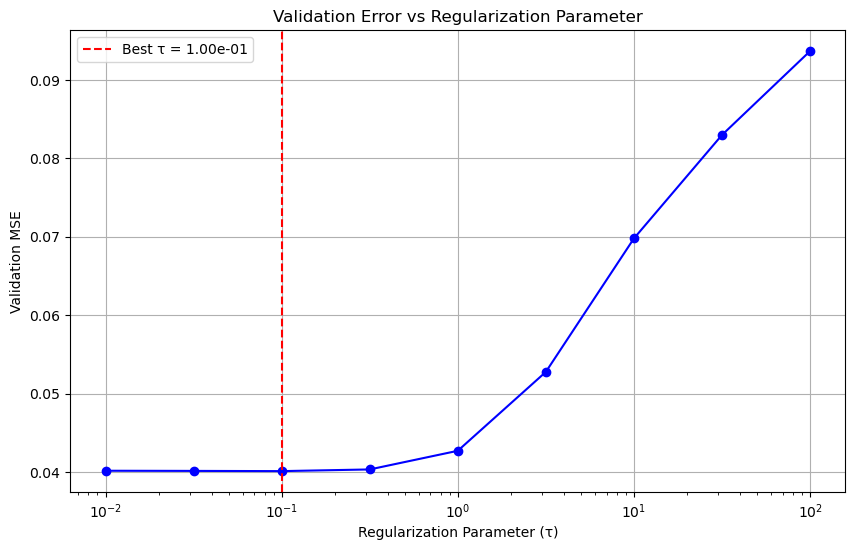

In [21]:
# Plot validation errors vs regularization parameters
plt.figure(figsize=(10, 6))
plt.semilogx(regularization_range, validation_errors, 'bo-')
plt.axvline(x=best_regularization, color='r', linestyle='--', label=f'Best τ = {best_regularization:.2e}')
plt.xlabel('Regularization Parameter (τ)')
plt.ylabel('Validation MSE')
plt.title('Validation Error vs Regularization Parameter')
plt.grid(True)
plt.legend()
plt.show()


### Train Model using optimal Tau

In [22]:
# Train and evaluate final model
final_model = LinearRegression(tau=best_regularization)
final_model.fit(X_train, y_train)


### Evaluating Model

In [23]:
def evaluate_model(model, X, y, name=""):
    """Evaluate model performance with detailed metrics."""
    y_pred = model.predict(X)
    mse = np.mean((y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y.mean()) ** 2)
    
    print(f"\n{name} Performance Metrics:")
    print("-" * 40)
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.6f}")
    
    return mse, rmse, r2

# Evaluate final model
custom_metrics = evaluate_model(final_model, X_test, y_test, "Custom Model")




Custom Model Performance Metrics:
----------------------------------------
MSE: 0.046336
RMSE: 0.215259
R²: 0.680124


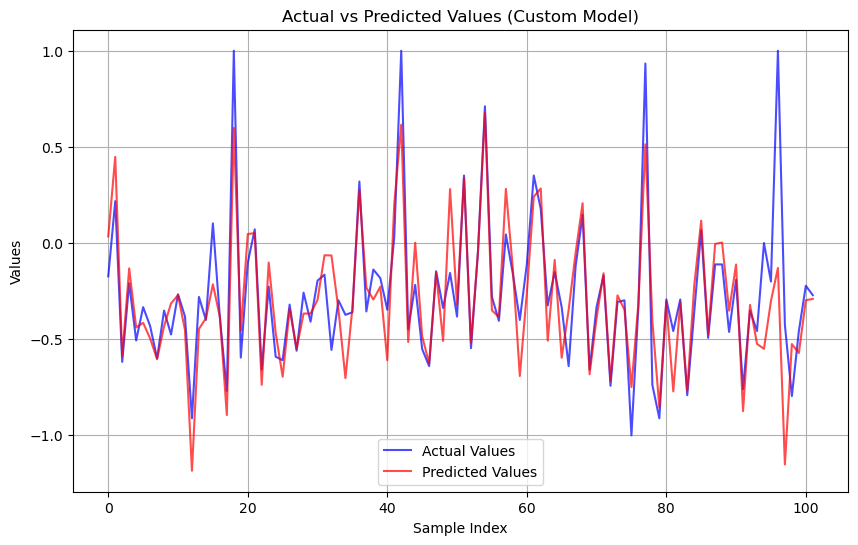

In [24]:
pred = final_model.predict(X_test)
# Create scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, 'b-', label='Actual Values', alpha=0.7)
plt.plot(range(len(pred)), pred, 'r-', label='Predicted Values', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values (Custom Model)')
plt.legend()
plt.grid(True)
plt.show()


### Reference

In [25]:
# Compare with sklearn's Ridge regression
ridge = Ridge(alpha=best_regularization)
ridge.fit(X_train[:, 1:], y_train)  # Exclude bias term for sklearn

# Create a wrapper class for sklearn model to match our interface
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        return self.model.predict(X[:, 1:])  # Exclude bias term

sklearn_wrapper = SklearnWrapper(ridge)
sklearn_metrics = evaluate_model(sklearn_wrapper, X_test, y_test, "sklearn Ridge")


sklearn Ridge Performance Metrics:
----------------------------------------
MSE: 0.046844
RMSE: 0.216435
R²: 0.676619


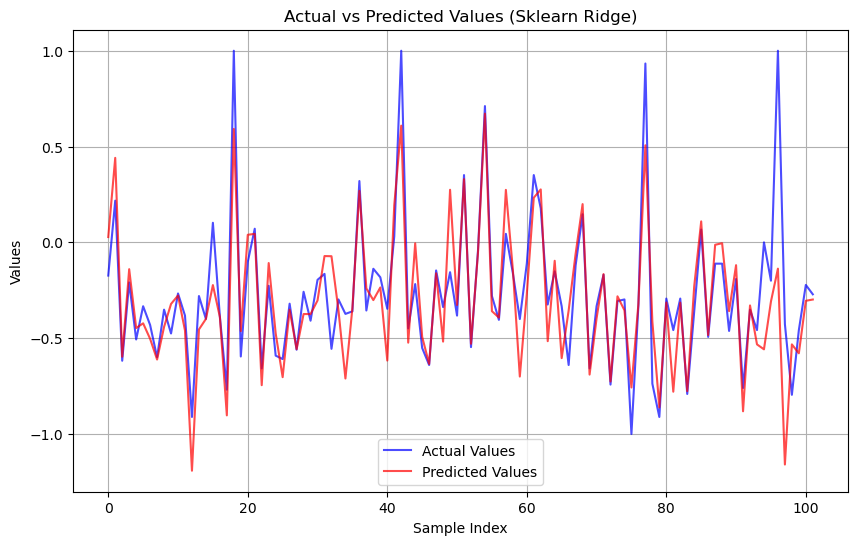

In [26]:
pred = ridge.predict(X_test[:, 1:])

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, 'b-', label='Actual Values', alpha=0.7)
plt.plot(range(len(pred)), pred, 'r-', label='Predicted Values', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values (Sklearn Ridge)')
plt.legend()
plt.grid(True)
plt.show()


### Comparison

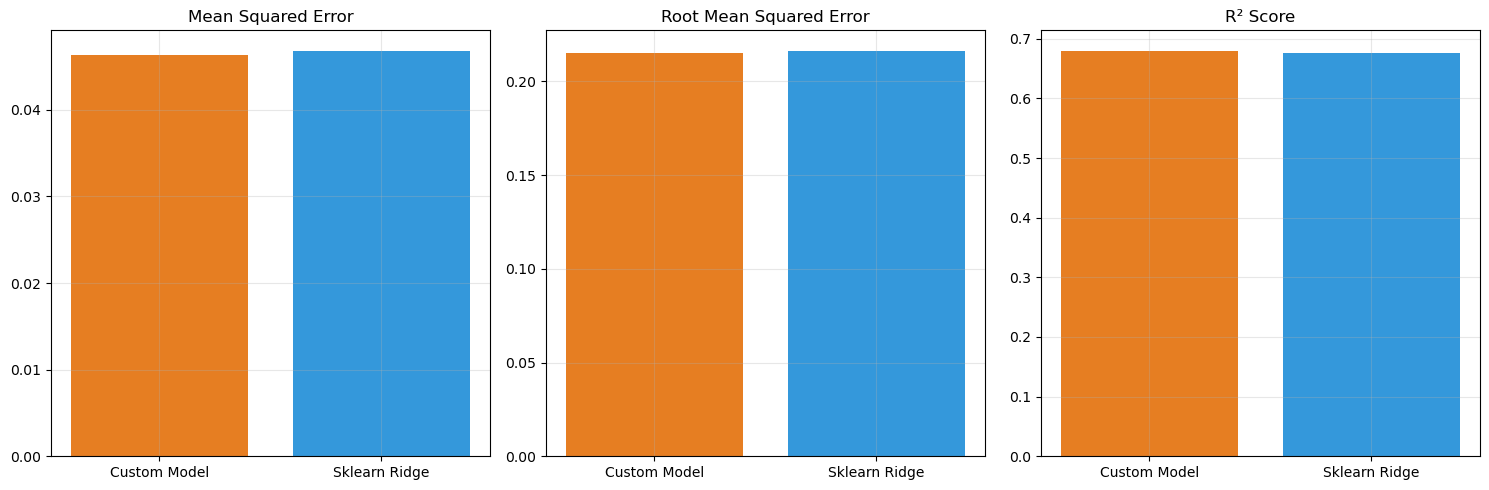

In [27]:
# Extract metrics for comparison
metrics = {
    'MSE': [custom_metrics[0], sklearn_metrics[0]],
    'RMSE': [custom_metrics[1], sklearn_metrics[1]], 
    'R²': [custom_metrics[2], sklearn_metrics[2]]
}

# Create subplots for each metric
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
models = ['Custom Model', 'Sklearn Ridge']
colors = ['#e67e22', '#3498db']  # Orange and blue colors

# Plot MSE comparison
ax1.bar(models, metrics['MSE'], color=colors)
ax1.set_title('Mean Squared Error')
ax1.grid(True, alpha=0.3)

# Plot RMSE comparison
ax2.bar(models, metrics['RMSE'], color=colors)
ax2.set_title('Root Mean Squared Error')
ax2.grid(True, alpha=0.3)

# Plot R² comparison
ax3.bar(models, metrics['R²'], color=colors)
ax3.set_title('R² Score')
ax3.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()
